In [2]:
%load_ext autoreload
%autoreload 2 
import matplotlib.pyplot as plt
import numpy as np
import ensemble_misfit_plot
#import seaborn as sns
from scipy import stats
import EnsembleVisualiser

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
ppv = EnsembleVisualiser.Ensemble('/Users/ja17375/Projects/Epac_fast_anom/HQ_data/ScS_fix_test/ppv_010_100/', strmax=0.5)

Model Config set as:
0 < alpha < 90
Beta = fixed
-180 < gamma < 180
0 < strength < 0.5


In [5]:
ppv.find_best_fitting()

The best fitting model is:
Alpha = 28.71106
Gamma = -14.64361
Strength = 0.25236
Model misfit = 0.31056


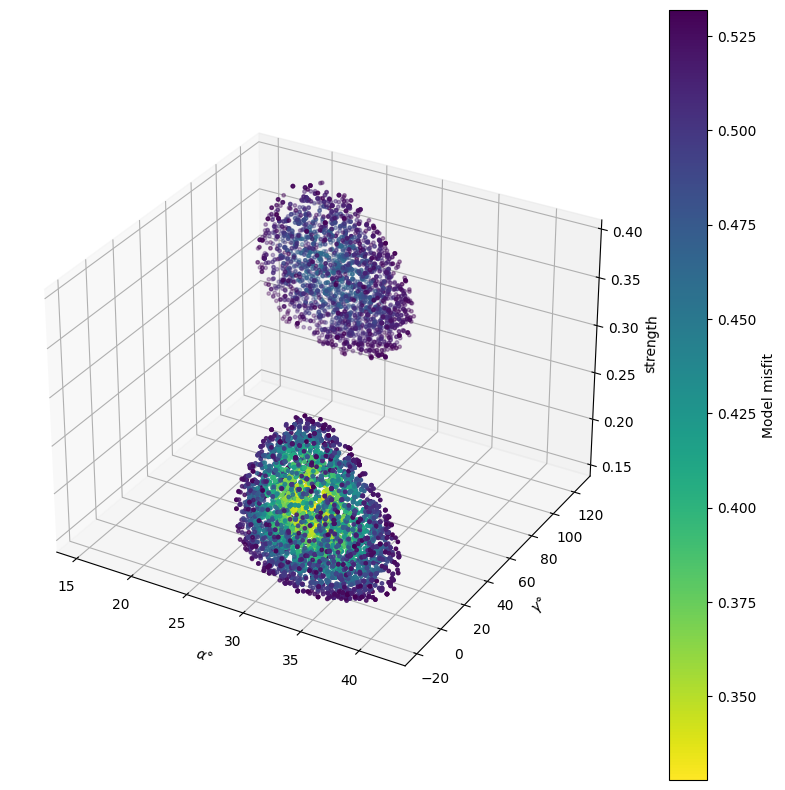

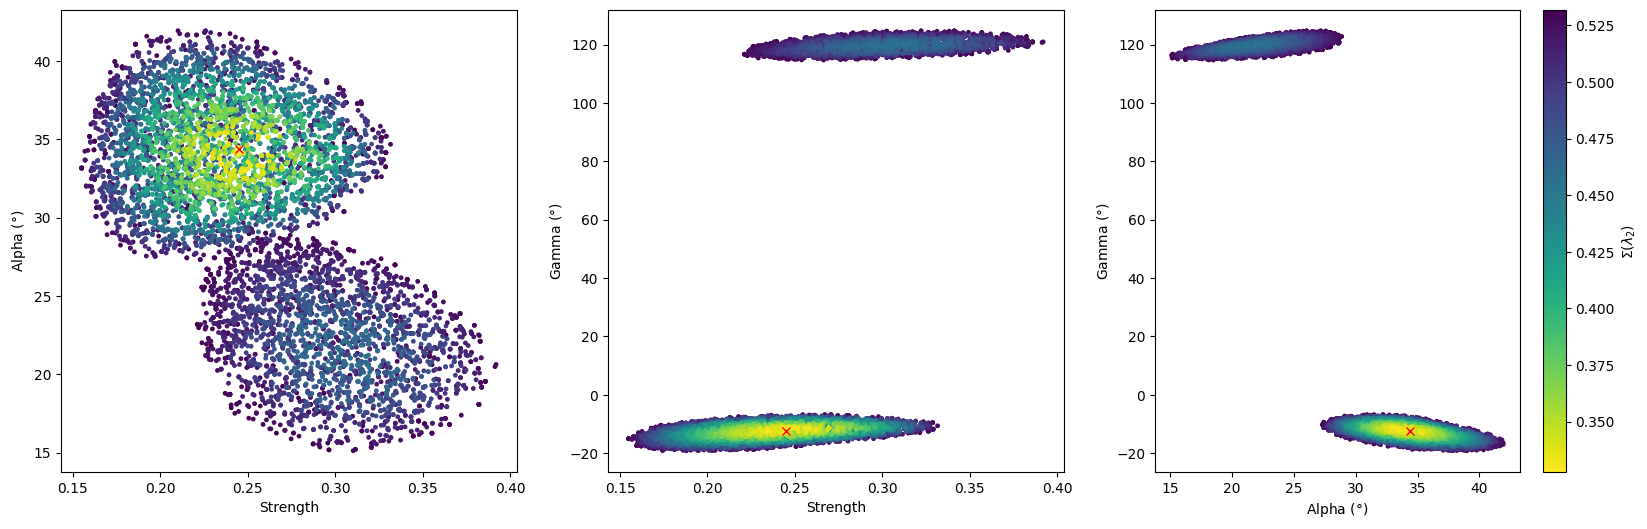

In [5]:
ensemble_misfit_plot.plot_nbest_models(ppv, 10000)

In [6]:
n = 10000 # Only consider 10000 best models
models_sort = ppv.models.sort_values(by=['misfit'])
pmodels = models_sort.iloc[0:n]

In [6]:
def add_1d_kde(ax, param, Ensemble):
    '''Make a KDE plot for input values.
    Which model parameter (alpha, gamma, strength, misfit) is determined by param'''
    ticks = None
    if param == 'alpha':
        x = np.linspace(0, 90, 1000)
        lim = [0, 90]
        ticks = [0,30, 60, 90]
    elif param == 'gamma':
        x = np.linspace(-180, 180, 2000)
        lim=[-180, 180]
        ticks = [-180,-90,0,90,180]
    elif param == 'strength':
        x = np.linspace(0, Ensemble.config['strength_max'], 1000)
        lim=[0, Ensemble.config['strength_max']]
    elif param == 'misfit':
        x = np.linspace(0, 1.5, 1000)
        lim=[0, 0.8]
        ticks = [0, 0.2, 0.4, 0.6]
    values = Ensemble.models[param]
    kde = stats.gaussian_kde(values)
    y = kde(x)
    ymax = np.max(y)*1.1
    ax.plot(x, y, 'k')
    if ticks:
        ax.set_xticks(ticks)
    ax.set_ylim([0, np.max(y)*1.1])

In [7]:
def get_param_lims(param, Ensemble):
    if param == 'alpha':
        lim = [0, 90]
    elif param == 'gamma':
        lim=[-180, 180]
    elif param == 'strength':
        lim=[0, Ensemble.config['strength_max']]
    elif param == 'misfit':
        x = np.linspace(0, 1.5, 1000)
        lim=[0, 0.8]
    return lim

In [8]:
def add_2d_kde(ax, Ensemble, xparam, yparam):
    '''Made a 2-D kernel desnity estimation plot for MTS Ensemble data'''
    # Get the correct x,y limits depending on input params
    xlim = get_param_lims(xparam, Ensemble)
    ylim = get_param_lims(yparam, Ensemble)
    # Set up samples 100 in both X and Y directions
    X, Y = np.mgrid[xlim[0]:xlim[1]:100j, ylim[0]:ylim[1]:100j]
    samples = np.vstack([X.ravel(), Y.ravel()])
    # Get params out of DF as numpy arrays
    x_models = Ensemble.models[xparam].values
    y_models = Ensemble.models[yparam].values
    # Stack params for KDE
    models = np.vstack([x_models, y_models])
    # 'make' KDE function
    kernal = stats.gaussian_kde(models)
    kde = kernal(samples).T
    # Now we have our KDE, reshape the array for plotting
    Z = np.reshape(kde, X.shape)
    ax.contourf(X, Y, Z, cmap=plt.cm.gist_earth_r, levels=10, vmin=1e-5)
    ax.contour(X, Y, Z, levels=10)
    print([xlim[0], xlim[1], ylim[0], ylim[1]])


In [9]:
def plot_model_ensemble(Ensemble):
    models = Ensemble.models
    fig, axs = plt.subplots(nrows=3, ncols=3, sharex = 'col')
    #0,0 Alpha v alpha
    add_1d_kde(axs[0,0], 'alpha', Ensemble)
    axs[0,0].set_xlim([0,90])
    #row 0, col 1
    add_2d_kde(axs[0,1], Ensemble, xparam='gamma', yparam='alpha')
    axs[0,1].set_xlim([-180,180])
    #row 0, col 2 
    add_2d_kde(axs[0,2], Ensemble, xparam='strength', yparam='alpha')
    axs[0,2].set_xlim([0, 0.4])
    #row 1, col 0 
    add_2d_kde(axs[1,0], Ensemble, xparam='alpha', yparam='gamma')
    #row 1, col 1
    add_1d_kde(axs[1,1], 'gamma', Ensemble)
    #row 1, col 2 
    add_2d_kde(axs[1,2], Ensemble, xparam='strength', yparam='gamma')
    #row 2, col 0 
    add_2d_kde(axs[2,0], Ensemble, xparam='alpha', yparam='strength')
    # row 2, col 1
    add_2d_kde(axs[2,1], Ensemble, xparam='gamma', yparam='strength')
    # row 2, col 2 
    add_1d_kde(axs[2,2], 'strength', Ensemble)
    plt.tight_layout()
    plt.show()

Lets try using Seaborn instead (UPDATE - this isn't great either)

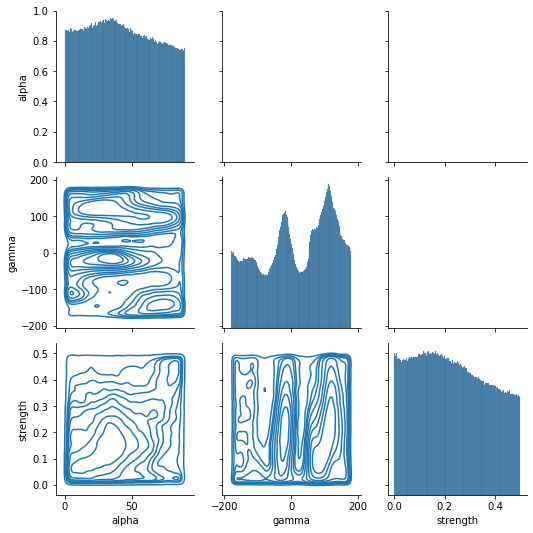

In [14]:
n = 10000 # Only consider 10000 best models
models_sort = ppv.models.sort_values(by=['misfit'])
pmodels = models_sort.iloc[0:n]
data = pmodels[['alpha','gamma','strength']]
full_dataset = ppv.models[['alpha','gamma','strength']]
grid = sns.PairGrid(full_dataset, diag_sharey=False)
grid.map_diag(sns.histplot)
grid.map_lower(sns.kdeplot)

Ok, so we have the see of an idea here. KDE plots may make the most sense here, but lets test building the frame with some simple 2-D data in order to get the plots set up correctly

In [54]:
def measure(n):
    "Measurement model, return two coupled measurements. Modified from SciPy docs (scipy.stats.gaussian_kde)"
    m1 = np.random.normal(size=n)
    m2 = np.random.normal(scale=0.5, size=n)
    return m1+m2, (m1-m2)*2

In [55]:
m1, m2 = measure(2000)
xmin = m1.min()
xmax = m1.max()
ymin = m2.min()
ymax = m2.max()

In [59]:
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([m1, m2])
kernel = stats.gaussian_kde(values)
Z = np.reshape(kernel(positions).T, X.shape)

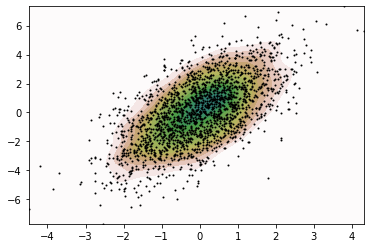

In [74]:

fig, ax = plt.subplots()
#ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r, extent=[xmin, xmax, ymin, ymax])
ax.contourf(X, Y, Z, cmap=plt.cm.gist_earth_r, levels=15,vmax=0.1, vmin=1e-2)
ax.plot(m1, m2, 'k.', markersize=2)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
plt.show()

So if we provide the X, Y, grid then contourf can figure out when to draw things... great!
Before building the huge grid of values, lets try a single 2-D KDE of our data

[0, 90, 0, 0.5]


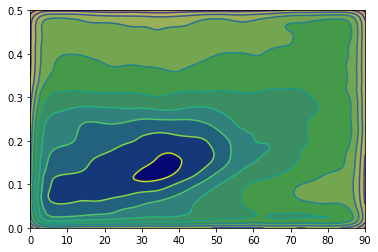

In [10]:
fig, ax = plt.subplots()
kde = add_2d_kde(ax, ppv, xparam='alpha', yparam='strength')

Lets borrow some code from stackoverflow to make the subplots square
https://stackoverflow.com/questions/51474842/python-interplay-between-axissquare-and-set-xlim/51483579#51483579

In [88]:
class SquareSubplots():
    def __init__(self, fig):
        self.fig = fig
        self.ax = self.fig.axes[0]
        self.figw,self.figh = 0,0
        self.params = [self.fig.subplotpars.left,
                       self.fig.subplotpars.right,
                       self.fig.subplotpars.top,
                       self.fig.subplotpars.bottom,
                       self.fig.subplotpars.wspace,
                       self.fig.subplotpars.hspace]
        self.rows, self.cols = self.ax.get_subplotspec().get_gridspec().get_geometry()
        self.update(None)
        self.cid = self.fig.canvas.mpl_connect('resize_event', self.update)


    def update(self, evt):
        figw,figh = self.fig.get_size_inches()
        if self.figw != figw or self.figh != figh:
            self.figw = figw; self.figh = figh
            l,r,t,b,wspace,hspace = self.params
            axw = figw*(r-l)/(self.cols+(self.cols-1)*wspace)
            axh = figh*(t-b)/(self.rows+(self.rows-1)*hspace)
            axs = min(axw,axh)
            w = (1-axs/figw*(self.cols+(self.cols-1)*wspace))/2.
            h = (1-axs/figh*(self.rows+(self.rows-1)*hspace))/2.
            self.fig.subplots_adjust(bottom=h, top=1-h, left=w, right=1-w)
            self.fig.canvas.draw_idle()


Now lets try again 

[-180, 180, 0, 90]
[0, 0.5, 0, 90]
[0, 90, -180, 180]
[0, 0.5, -180, 180]
[0, 90, 0, 0.5]
[-180, 180, 0, 0.5]


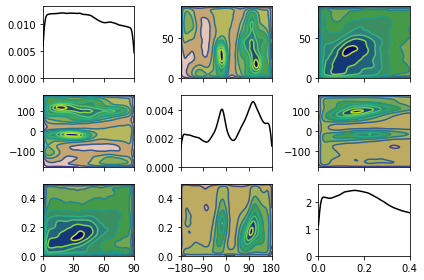

In [91]:
plot_model_ensemble(ppv)

At this point I think it is time to flesh out some ''proper'' python code to make this plot - rather than just relying on this notebook!